In [1]:
import numpy as np
import pandas as pd


import json
import os

import subprocess

from matplotlib import pyplot as plt

In [7]:
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
import torch
from torch import nn
from torch import optim

from tensorboardX import SummaryWriter

In [88]:
from importlib import reload
from utils import dataset

reload(dataset)

<module 'utils.dataset' from '/Users/sergmiller/Documents/my/lux-ai-v1/research/utils/dataset.py'>

In [5]:
def learn(train, val, model_ff, criterion, epochs=5, batch_size=64, shuffle=True, freq=10,lr=1e-3, l2=1e-5, use_tb=True): 
    if use_tb:
        writer = SummaryWriter()
    
    np.random.seed(1)
    ids_nn = np.arange(train.targets.shape[0])
    
    reshape_to_last = lambda x: torch.reshape(x, [np.prod(x.shape[:-1]), x.shape[-1]])

    optimizer = optim.Adam(model_ff.parameters(), lr=lr, weight_decay=l2)

    time_for_print_loss = lambda i: (i + 1) % freq == 0
    
    n_iter = 0
    

    for epoch in np.arange(epochs):
        np.random.shuffle(ids_nn)

        model_ff.train(True)

        for b in np.arange(0, train.targets.shape[0], batch_size):
            X_batch = torch.FloatTensor(train.features[ids_nn[b:b+batch_size]])
            y_batch = torch.FloatTensor(train.weights[ids_nn[b:b+batch_size]])  # reward(advantage)
            a_batch = torch.LongTensor(train.targets[ids_nn[b:b+batch_size]])  # action

            optimizer.zero_grad()
            y_pred_logits = model_ff(X_batch)

            loss = criterion(y_pred_logits, y_batch, a_batch, X_batch)
            loss.backward()

            optimizer.step()

            if (b // batch_size + 1) % freq == 0:
                print('train loss in %d epoch in %d batch: %.5f' %
                  (epoch + 1, b // batch_size + 1, loss.item()))
                
                if use_tb:
                    writer.add_scalar('data/train_loss', loss.item(), n_iter)
                    writer.add_scalar('data/epoch', epoch + 1, n_iter)
                    writer.add_scalar('data/batch', b // batch_size + 1, n_iter)

                val_loss = 0
                its = 0
                model_ff.train(False)
                for b in np.arange(0, val.targets.shape[0], batch_size):
                    its += 1
                    X_batch = torch.FloatTensor(val.features[b:b+batch_size])
#                     X_batch = reshape_to_last(X_batch)

                    y_batch = torch.FloatTensor(val.weights[b:b+batch_size])
                    a_batch = torch.LongTensor(val.targets[b:b+batch_size])
                    with torch.no_grad():
                        y_pred_logits = model_ff(X_batch)
                    loss = criterion(y_pred_logits, y_batch, a_batch, X_batch)
                    val_loss += loss.item()
                val_loss /= its
                print('val loss in %d epoch: %.5f' % (epoch + 1, val_loss))
                
                if use_tb:
                    writer.add_scalar('data/val_loss', val_loss, n_iter)
                n_iter += 1


In [96]:
datasets = dataset.read_datasets_from_dir("features_v3/")

In [97]:
dataset.read_columns_from_random_file("features_v3")

[(0, 'cargo_vol_total'),
 (1, 'cargo_fuel_total'),
 (2, 'unit_can_build'),
 (3, 'unit_routine'),
 (4, 'unit_last_action'),
 (5, 'near_city_dist'),
 (6, 'near_city_dir'),
 (7, 'near_city_fuel'),
 (8, 'near_city_light_upkeep'),
 (9, 'city_size'),
 (10, 'opp_near_city_dist'),
 (11, 'opp_near_city_dir'),
 (12, 'opp_near_city_fuel'),
 (13, 'opp_near_city_light_upkeep'),
 (14, 'opp_city_size'),
 (15, 'near_resource_dist'),
 (16, 'near_resource_dir'),
 (17, 'near_resource_type'),
 (18, 'near_resource_amount'),
 (19, 'my_city_count'),
 (20, 'opp_city_count'),
 (21, 'turn'),
 (22, 'is_night'),
 (23, 'time_to_night'),
 (24, 'width'),
 (25, 'height'),
 (26, 'my_research'),
 (27, 'opp_research'),
 (28, 'my_research_coal'),
 (29, 'opp_research_coal'),
 (30, 'my_research_uran'),
 (31, 'opp_research_uran'),
 (32, 'action'),
 (33, 'my_tiles'),
 (34, 'opp_tiles')]

In [98]:
trainD = dataset.concat_datasets(datasets[:-50])
valD = dataset.concat_datasets(datasets[-50:])

In [99]:
trainD.features[:, 4]

array(['None', 'w', 'e', ..., 'p', 'p', 'p'], dtype=object)

In [100]:
dataset.CAT_FEATURES

[2, 3, 4, 6, 11, 16, 17, 22, 28, 29, 30, 31]

In [101]:
trainD.features.shape

(2533363, 32)

In [19]:
FLOAT_FEATURES = [i for i in range(32) if i not in dataset.CAT_FEATURES]

In [20]:
FLOAT_FEATURES

[0, 1, 5, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27]

In [104]:
trainD.features.shape

(2533363, 32)

In [6]:
import pickle
from sklearn.preprocessing import OneHotEncoder

In [8]:
with open("../submissions/simple/models/ohe_v1", "rb") as f:
    OHE = pickle.load(f)

In [21]:
def prepare_features(t: dataset.Dataset, v: dataset.Dataset) -> (dataset.Dataset, dataset.Dataset):
#     ohe = OneHotEncoder(sparse=False)
    def prepare(d, is_train):
        cf = d.features[:, dataset.CAT_FEATURES]
        ff = d.features[:, FLOAT_FEATURES]
        ff[ff == "None"] = 0
        cf_o = OHE.fit_transform(cf) if is_train else OHE.transform(cf)
        return dataset.Dataset(
            features=np.array(np.concatenate([cf_o, ff], axis=1), dtype=np.float),
            targets=np.array(d.targets, dtype=np.float),
            weights=np.array(d.weights, dtype=np.float)
        )
    t = prepare(t, False)
    v = prepare(v, False)
    return (t,v)

In [142]:
# with open("../submissions/simple/models/ohe_v1", "wb") as f:
#     pickle.dump(ohe, f)

In [114]:
trainD_ohe.targets, trainD_ohe.weights

(array([5, 4, 5, ..., 1, 1, 1]),
 array([-2, -2, -2, ..., 0, 0, 0], dtype=object))

In [101]:
trainD_ohe, valD_ohe = prepare_features(trainD, valD)

In [116]:
trainD_ohe.features.shape

(2533363, 63)

In [102]:
class NNWithCustomFeatures(nn.Module):
    def __init__(self, INPUT_F, DROP_P, H, A=6):
        super().__init__()
        INPUT_F_C = INPUT_F
        self.model_ff =  nn.Sequential(
            nn.BatchNorm1d(INPUT_F_C),
            nn.Dropout(DROP_P),
            nn.Linear(INPUT_F_C, H),
            nn.ReLU(),
            nn.Dropout(DROP_P),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, A)
#             nn.Sigmoid()
        )

    def forward(self, x):
#         input_x = torch.cat([x], axis=1)
        return self.model_ff(x)

In [111]:
model = NNWithCustomFeatures(63, 0.05, 64)

In [113]:
ENTROPY_REG = 1e-5
def policy_loss(pi_logits, reward_batch, a_batch, X_batch):
    pi_probs = torch.nn.Softmax(dim=1)(pi_logits)
    return torch.mean(torch.nn.CrossEntropyLoss(reduction='none')(pi_logits, a_batch) * reward_batch 
                      - torch.sum(pi_probs * torch.log(pi_probs) * ENTROPY_REG, dim=1))

In [ ]:
learn(trainD_ohe, valD_ohe, model, policy_loss, lr=1e-4, batch_size=32, epochs=5, freq=64, l2=1e-5)

train loss in 1 epoch in 64 batch: 33.62749
val loss in 1 epoch: 27.46838
train loss in 1 epoch in 128 batch: 33.35194
val loss in 1 epoch: 27.00126
train loss in 1 epoch in 192 batch: 27.84943
val loss in 1 epoch: 26.51209
train loss in 1 epoch in 256 batch: 33.79417
val loss in 1 epoch: 25.98330
train loss in 1 epoch in 320 batch: 21.44173
val loss in 1 epoch: 25.44491
train loss in 1 epoch in 384 batch: 37.08883
val loss in 1 epoch: 24.86610
train loss in 1 epoch in 448 batch: 32.10423
val loss in 1 epoch: 24.28592
train loss in 1 epoch in 512 batch: 32.83151
val loss in 1 epoch: 23.70958
train loss in 1 epoch in 576 batch: 28.95453
val loss in 1 epoch: 23.13052
train loss in 1 epoch in 640 batch: 23.10432
val loss in 1 epoch: 22.59232
train loss in 1 epoch in 704 batch: 27.52392
val loss in 1 epoch: 22.07282
train loss in 1 epoch in 768 batch: 20.83056
val loss in 1 epoch: 21.61408
train loss in 1 epoch in 832 batch: 25.31148
val loss in 1 epoch: 21.17967
train loss in 1 epoch in 8

In [54]:
torch.Tensor([1,2,0])

tensor([1., 2., 0.])

In [57]:
torch.randn(2, 3)

tensor([[-1.8303,  0.1936,  0.8113],
        [ 0.8070, -0.6903, -0.6328]])

In [58]:
torch.nn.CrossEntropyLoss(reduction='none')(torch.randn(2, 3), torch.LongTensor([1,2]))

tensor([2.6177, 0.9913])

In [186]:
torch.save(model.state_dict(), '../submissions/simple/models/policy_v1')

In [181]:
model.forward(torch.Tensor(trainD_ohe.features[0]).reshape(1, -1))

tensor([[  4.7694, -46.3936,  -7.7365,  -9.8257,   0.2452,  59.4586]],
       grad_fn=<ThAddmmBackward>)

In [184]:
p = model.forward(torch.Tensor(trainD_ohe.features[0]).reshape(1, -1)).cpu().detach().numpy().reshape(-1)
p = np.clip(p, -30, 30)

In [185]:
np.exp(p) / np.sum(np.exp(p))

array([1.10283675e-11, 8.75651089e-27, 4.08547019e-17, 5.05711219e-18,
       1.19576061e-13, 1.00000000e+00], dtype=float32)

In [147]:
ohe.categories_

[array([False, True], dtype=object),
 array([1, 2, 3], dtype=object),
 array(['None', 'bcity', 'e', 'n', 'p', 's', 'w'], dtype=object),
 array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', 'coal', 'uranium', 'wood'], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object)]

In [148]:
trainD.features[0]

array([0, 0, False, 2, 'None', 0, 'c', 0.0, 23.0, 1, 1, 'n', 0.0, 23.0, 1,
       1, 'w', 'wood', 800, 1, 1, 0, False, 30, 16, 16, 0, 0, False,
       False, False, False], dtype=object)

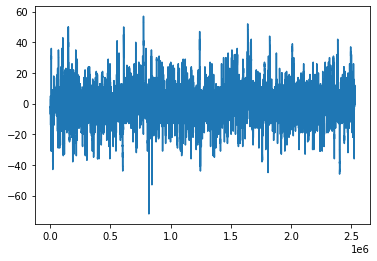

In [151]:
plt.plot(trainD.weights)

In [24]:
simple_bot = "../submissions/simple/main.py"
replays = "replays"

def run_game(left_bot=simple_bot, right_bot=simple_bot, seed=42, loglevel=2):
    replay_path = "replay.json"
    python_v = "python3.7"
    
    replay_path = os.path.join(replays, str(np.random.randint(1e9)) + ".json")
    
    size = np.random.choice([12,16,24,32], size=1)[0]
    
    res = subprocess.run([
        "lux-ai-2021",
        left_bot,
        right_bot,
#         "--statefulReplay",
        "--width={}".format(size),
        "--height={}".format(size),
        "--loglevel={}".format(loglevel),
        "--python={}".format(python_v),
        "--seed={}".format(seed),
        "--out={}".format(replay_path)], stdout=subprocess.PIPE)
    
    if loglevel > 0:
        print(res.stdout.decode())

    assert res.returncode == 0

    with open(replay_path, "r") as f:
        result = json.load(f)
    return result, res.stdout.decode()

In [25]:
import hashlib

def build_runnable_bot_with_flags(flags: dict, origin = simple_bot, base_path = '../submissions/simple/') -> str:
    lines = []
    with open(origin, "r") as f:
        for line in f:
            lines.append(line[:-1])
    text = '\n'.join(lines)
    f = json.dumps(flags)
    text = text.format(f)
    h = int(hashlib.sha256(f.encode('utf-8')).hexdigest(), 16) % (10 ** 18)
    path = base_path + "main_" + str(h) + ".py"
    with open(path, "w") as f:
        f.write(text)
    return path

In [26]:
def count_series(results: list):
    wins = []
    for i, r in enumerate(results):
        ranks = r[0]['results']['ranks']
        teams = r[0]['teamDetails']
        if ranks[0]['rank'] == 1 and ranks[1]['rank'] == 2:
            if ranks[0]["agentID"] == i % 2:
                wins.append(1)
            else:
                wins.append(0)
        else:
            wins.append(0.5)
    return wins

In [27]:
from joblib import Parallel, delayed
import tqdm

In [28]:
def sample_dataset(d, p=0.5):
    N = len(d.features)
    ids = np.random.choice(N, size=int(N * p))
    return dataset.Dataset(features = d.features[ids], weights = d.weights[ids], targets = d.targets[ids])

In [95]:
t = 0
B = 4

model = NNWithCustomFeatures(63, 0.05, 64)

while True:
    t += 1
    torch.save(model.state_dict(), '../submissions/simple/models/policy_iter_v{}'.format(t))
    data = []
    r = []
    for i in np.arange(B):
        seed = t * B + i
        _f = str(seed) + ".txt"
        bot = build_runnable_bot_with_flags({
            "model_path": "models/policy_iter_v{}".format(t), 
            "use_policy": True,
            "is_neural": True,
            "prob_use_default_agent": 0.1,
            "ohe_path": "models/ohe_v1",
            "use_old_units_cargo_rules": False,
            "log_features_path": "../../research/features_iter/", "log_path_file_name": _f
        })
        if i % 2 == 0:
            _r = run_game(bot, simple_bot, loglevel=0, seed=seed)
        else:
            _r = run_game(simple_bot, bot, loglevel=0, seed=seed)
        r.append(_r)
        data.append(dataset.get_dataset_from_file(os.path.join("features_iter/", _f)))
    trainD = dataset.concat_datasets(data)
#     valD = sample_dataset(dataset.concat_datasets(data))
    trainD_ohe, valD_ohe = prepare_features(trainD, trainD)
    max_step = np.max(trainD.features[:, 21])
    print("Round {}, winrate: {}, max_step: {}, example: {}".format(t, np.mean(count_series(r)), max_step, r[0][0]['results']))
    learn(trainD_ohe, valD_ohe, model, policy_loss, lr=1e-5 / np.log(t + 1), batch_size=64, epochs=1, freq=1, l2=1e-3, use_tb=False)

Round 1, winrate: 0.0, max_step: 110, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/907588952.json'}
train loss in 1 epoch in 1 batch: -0.78826
val loss in 1 epoch: -0.84482
train loss in 1 epoch in 2 batch: -0.80270
val loss in 1 epoch: -0.84499
train loss in 1 epoch in 3 batch: -0.89367
val loss in 1 epoch: -0.84518
Round 2, winrate: 0.0, max_step: 237, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/934876622.json'}
train loss in 1 epoch in 1 batch: 5.13725
val loss in 1 epoch: 4.61682
train loss in 1 epoch in 2 batch: 5.55042
val loss in 1 epoch: 4.61601
train loss in 1 epoch in 3 batch: 5.02045
val loss in 1 epoch: 4.61514
train loss in 1 epoch in 4 batch: 5.37316
val loss in 1 epoch: 4.61426
train loss in 1 epoch in 5 batch: 5.22674
val loss in 1 epoch: 4.61335
train loss in 1 epoch in 6 batch: 5.83689
val loss in 1 epoch: 4.61244
train loss in 1 epoch in 7 batch: 4.49776
val los

KeyboardInterrupt: 

In [247]:
# model.forward(torch.Tensor(trainD_ohe.features[0]).reshape(1, -1))